 # Optimisation de Portefeuille avec Python
 Ce notebook explore l'optimisation de portefeuille en utilisant des données historiques de plusieurs actions. Nous allons :
 1. Charger les données historiques.
 2. Calculer les rendements et les risques.
 3. Optimiser le portefeuille pour maximiser le ratio de Sharpe, minimiser le risque, et atteindre des rendements cibles.
 4. Visualiser les résultats avec des graphiques.



 ## 1. Importation des Bibliothèques
 Nous commençons par importer les bibliothèques nécessaires pour l'analyse et la visualisation.

In [16]:
import yfinance as yf  # Pour récupérer les données boursières
import matplotlib.pyplot as plt  # Pour les visualisations
import seaborn as sns  # Pour des graphiques plus avancés
import numpy as np  # Pour les calculs numériques
from scipy.optimize import minimize  # Pour l'optimisation



 ## 2. Configuration Initiale
 Nous définissons des constantes utiles pour l'analyse, comme le nombre de jours de trading par an et le taux sans risque.

In [17]:
TRADING_DAYS_PER_YEAR = 252  # Nombre de jours de trading dans une année
RISK_FREE_RATE = 0.0619  # Taux sans risque de 6.19%
np.random.seed(41)  # Pour assurer la reproductibilité des résultats



 ## 3. Chargement des Données Historiques
 Nous chargeons les données historiques des actions sélectionnées à l'aide de `yfinance`.

In [18]:
# Fonction pour charger les données
def load_data(tickers, start_date, end_date):
    """Charge les prix de clôture des actions pour une période donnée."""
    data = yf.download(tickers, start=start_date, end=end_date)
    closing_prices = data["Close"]
    return closing_prices


# Sélection des actions à analyser
tickers = list(
    set(
        [
            "AAPL",
            "MSFT",
            "GOOGL",
            "AMZN",
            "TSLA",
            "META",
            "NVDA",
            "NFLX",
            "JPM",
            "V",
            "SNAP",
        ]
    )
)

# Chargement des données de 2018 à 2022
closing_prices = load_data(tickers, "2018-01-01", "2022-12-31")

[*********************100%***********************]  11 of 11 completed




 ## 4. Visualisation des Prix de Clôture
 Nous traçons les prix de clôture des actions pour observer leur évolution dans le temps.

<Figure size 1500x3000 with 0 Axes>

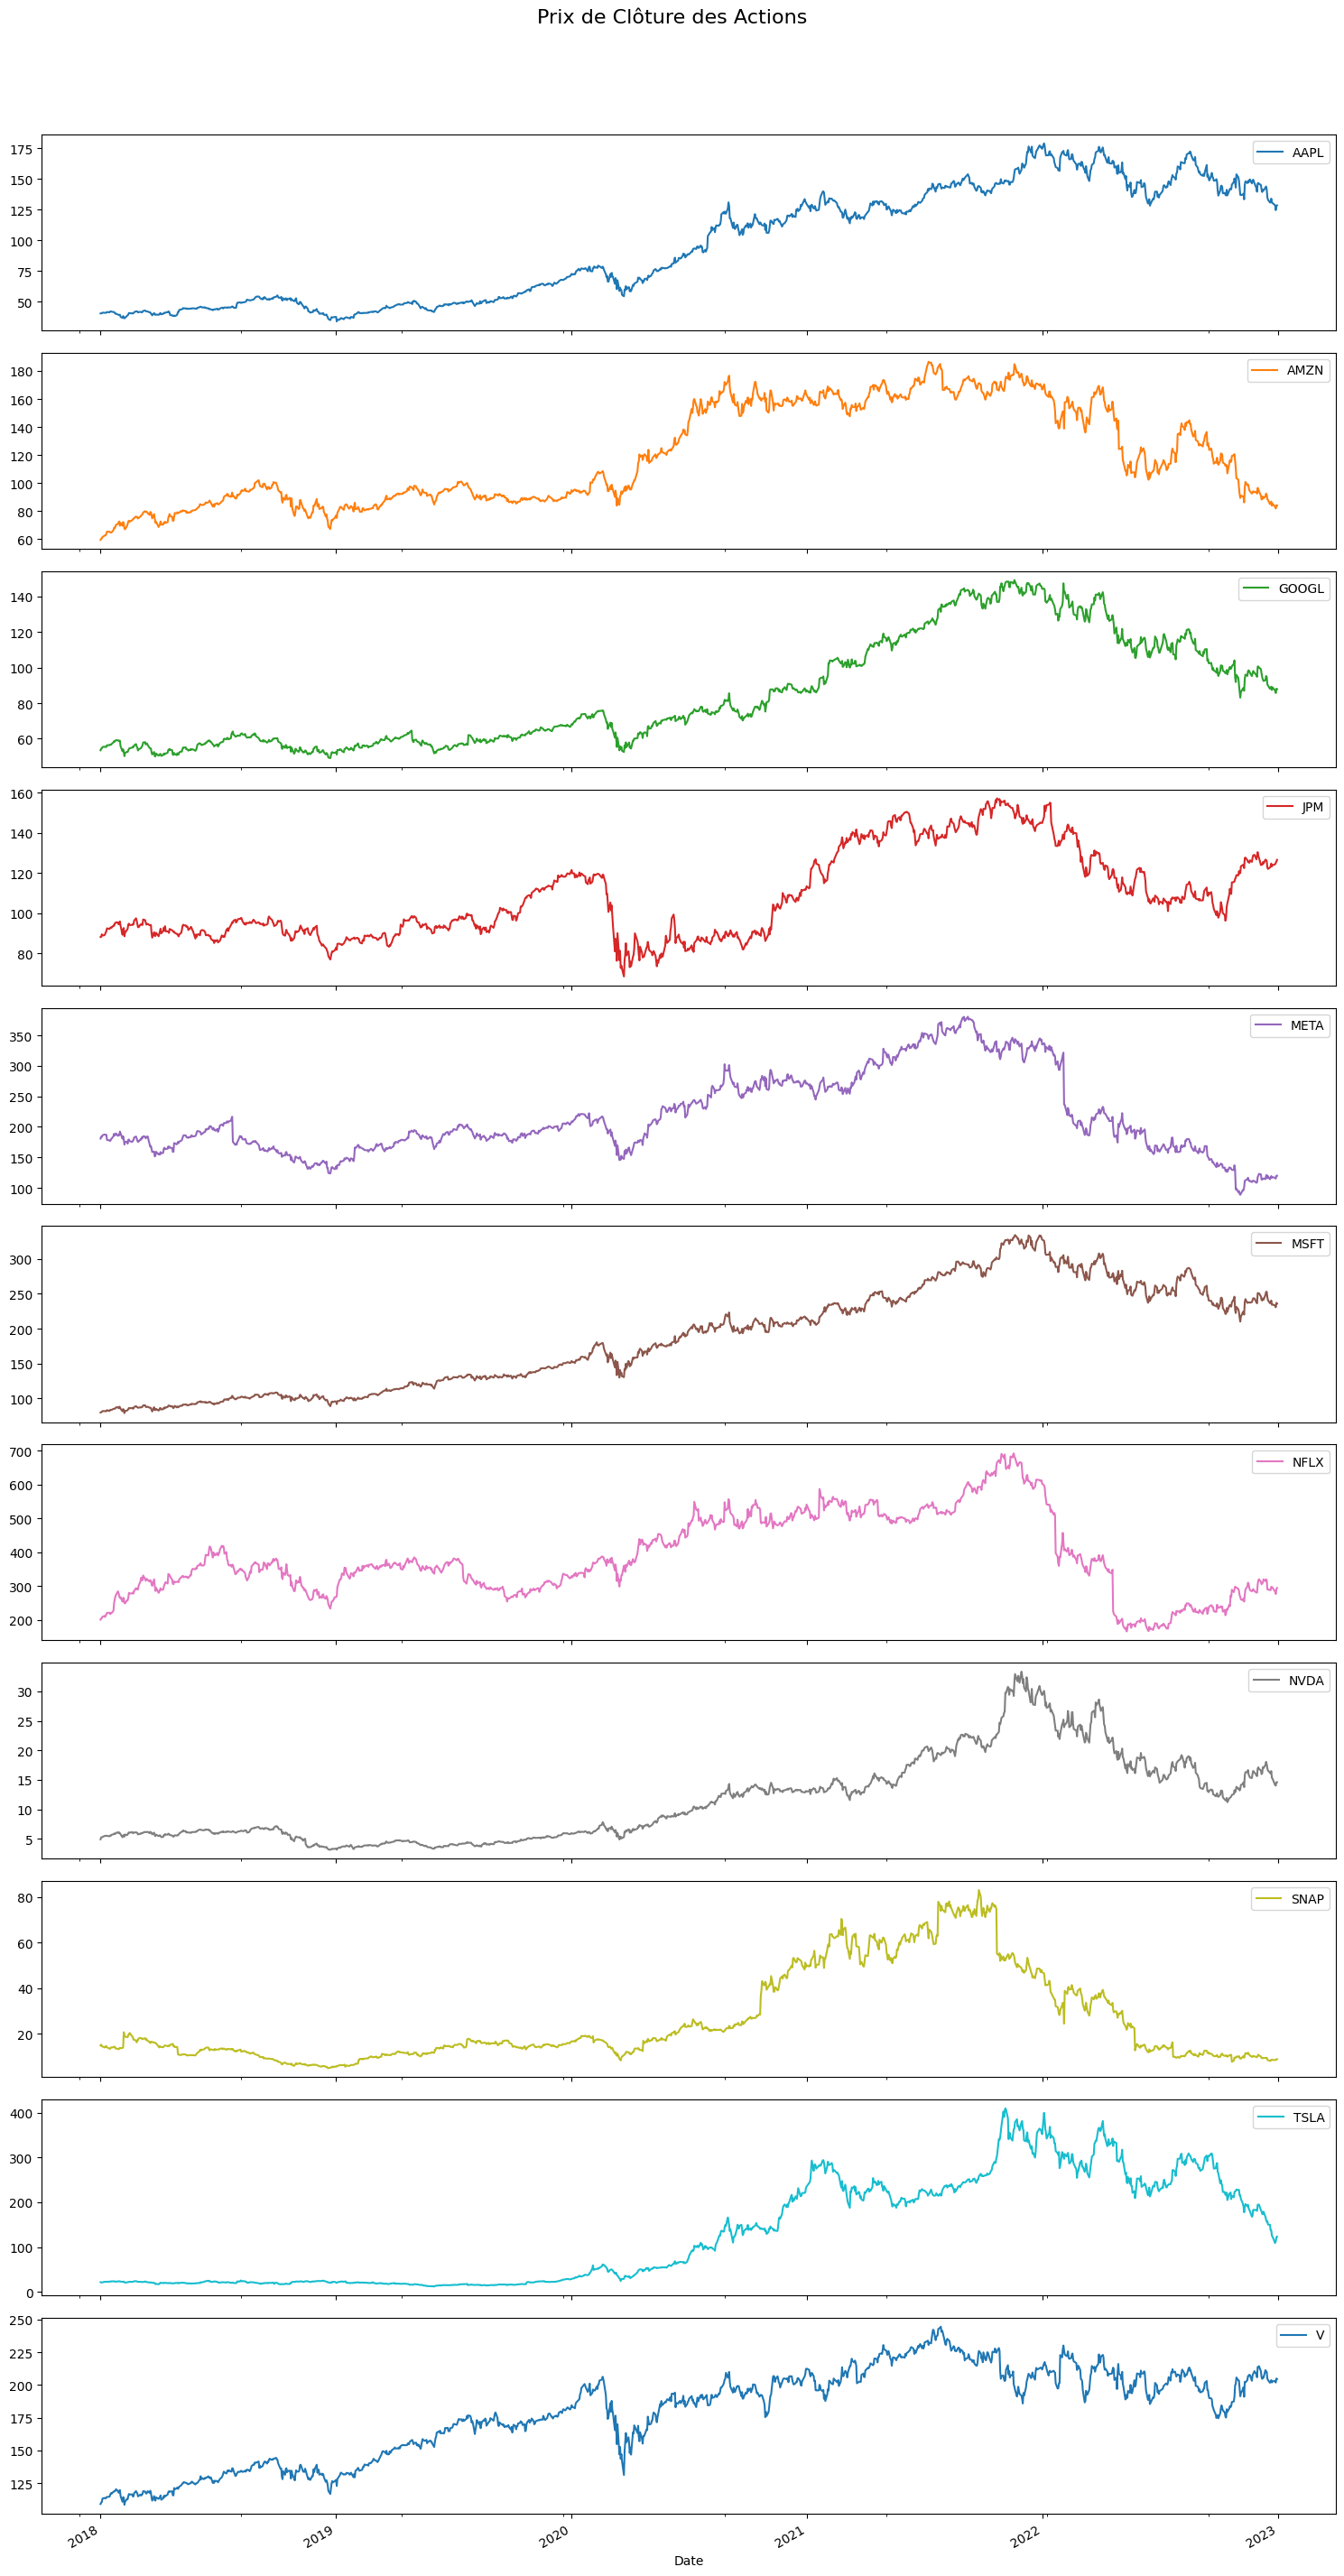

In [19]:
def plot_closing_prices(closing_prices):
    """Affiche les prix de clôture des actions."""
    plt.figure(figsize=(15, 30))
    closing_prices.plot(subplots=True, figsize=(15, 30))
    plt.suptitle("Prix de Clôture des Actions", fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


plot_closing_prices(closing_prices)


 ## 5. Calcul des Rendements Quotidiens
 Nous calculons les rendements quotidiens, qui sont essentiels pour l'analyse de risque et de rendement.

In [20]:
def calculate_daily_returns(closing_prices):
    """Calcule les rendements quotidiens des actions."""
    return closing_prices.pct_change().dropna()


daily_returns = calculate_daily_returns(closing_prices)


 ## 6. Analyse de Corrélation
 Nous visualisons les corrélations entre les rendements des actions pour comprendre leurs relations.

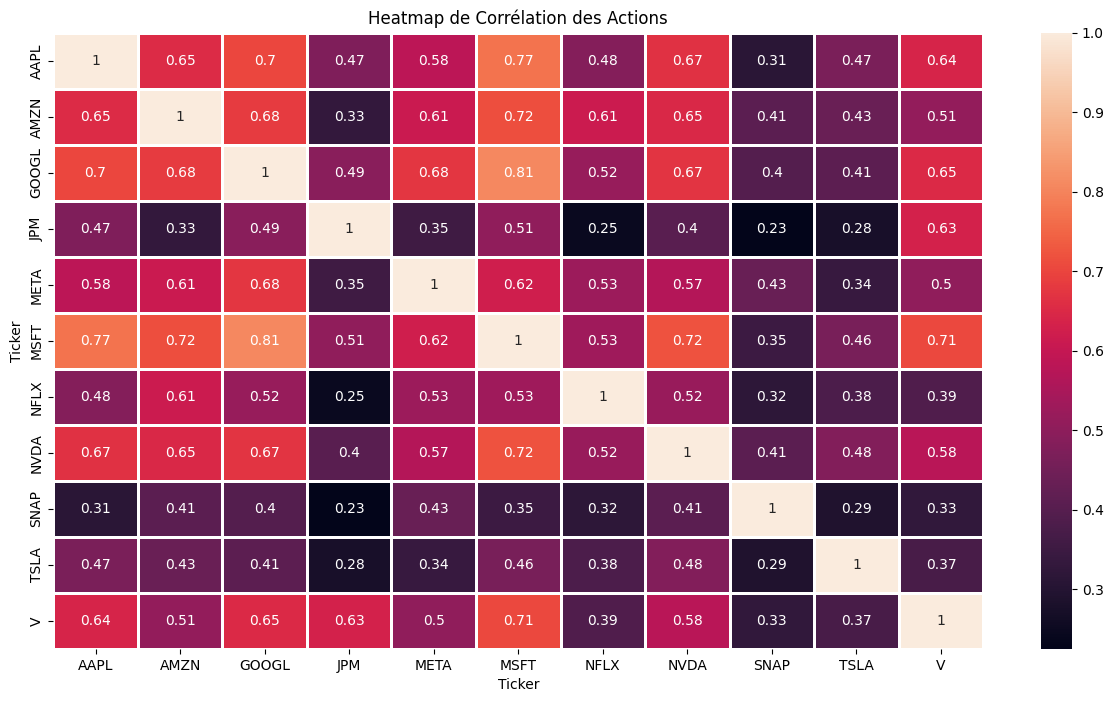

In [21]:
# Heatmap de corrélation
plt.figure(figsize=(15, 8))
sns.heatmap(daily_returns.corr(), linecolor="white", linewidths=1, annot=True)
plt.title("Heatmap de Corrélation des Actions")
plt.show()

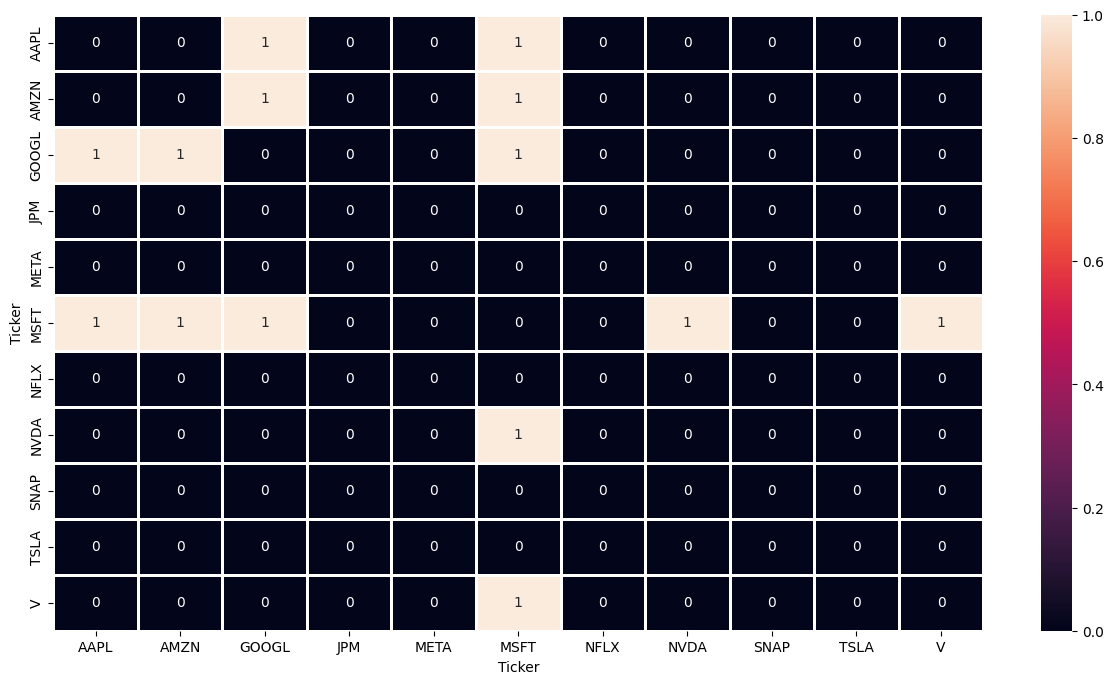

In [22]:
plt.figure(figsize=(15, 8))
c = daily_returns.corr()
sns.heatmap(
    ((c > 0.68) | (c < -0.68)) & (c != 1), linecolor="white", linewidths=1, annot=True
)
plt.show()


 ## 7. Calcul des Métriques Annualisées
 Nous calculons les rendements annualisés et la covariance annualisée pour l'optimisation du portefeuille.

In [23]:
def calculate_annualized_returns(daily_returns):
    """Calcule les rendements annualisés."""
    return (1 + daily_returns.mean()) ** TRADING_DAYS_PER_YEAR - 1


def calculate_annualized_covariance(daily_returns):
    """Calcule la covariance annualisée."""
    return daily_returns.cov() * TRADING_DAYS_PER_YEAR


annualized_returns = calculate_annualized_returns(daily_returns)
annualized_covariance = calculate_annualized_covariance(daily_returns)


 ## 8. Optimisation du Portefeuille
 Nous optimisons le portefeuille pour maximiser le ratio de Sharpe, minimiser le risque, et atteindre des rendements cibles.

In [24]:
def generate_random_weights(num_assets):
    """Génère des poids aléatoires pour le portefeuille."""
    return np.random.dirichlet(np.ones(num_assets))


def calculate_portfolio_performance(weights, daily_returns):
    """Calcule le rendement, le risque et le ratio de Sharpe du portefeuille."""
    annualized_returns = calculate_annualized_returns(daily_returns)
    annualized_covariance = calculate_annualized_covariance(daily_returns)
    portfolio_return = np.sum(annualized_returns * weights)
    portfolio_risk = np.sqrt(np.dot(weights.T, np.dot(annualized_covariance, weights)))
    sharpe_ratio = (portfolio_return - RISK_FREE_RATE) / portfolio_risk
    return {
        "return": portfolio_return,
        "risk": portfolio_risk,
        "sharpe_ratio": sharpe_ratio,
    }


 ### 8.1 Maximisation du Ratio de Sharpe
 Nous optimisons le portefeuille pour maximiser le ratio de Sharpe.

In [25]:
def optimize_with_max_sharpe_ratio(daily_returns, num_assets):
    """Optimise le portefeuille pour maximiser le ratio de Sharpe."""

    def negative_sharpe_ratio(weights):
        return (-1) * calculate_portfolio_performance(weights, daily_returns)[
            "sharpe_ratio"
        ]

    result = minimize(
        negative_sharpe_ratio,
        generate_random_weights(num_assets),
        method="SLSQP",
        constraints=[{"type": "eq", "fun": lambda w: np.sum(w) - 1.0}],
        bounds=[(0.0, 1.0) for _ in range(num_assets)],
    )
    return result


optimize_with_max_sharpe_ratio(daily_returns, len(tickers))

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: -1.1258542104945028
       x: [ 3.110e-01  1.219e-16  2.308e-16  0.000e+00  0.000e+00
            2.038e-01  0.000e+00  4.922e-17  2.621e-17  4.852e-01
            0.000e+00]
     nit: 9
     jac: [-1.474e-01  2.367e-01  1.300e-01  3.333e-02  5.432e-01
           -1.483e-01  1.154e-01 -1.202e-01  1.832e-01 -1.477e-01
           -6.827e-03]
    nfev: 108
    njev: 9


 ### 8.2 Minimisation du Risque
 Nous optimisons le portefeuille pour minimiser le risque.

In [26]:
def optimize_min_risk(daily_returns, num_assets):
    """Optimise le portefeuille pour minimiser le risque."""

    def minimize_risk(weights):
        return calculate_portfolio_performance(weights, daily_returns)["risk"]

    result = minimize(
        minimize_risk,
        generate_random_weights(num_assets),
        method="SLSQP",
        constraints=[{"type": "eq", "fun": lambda w: np.sum(w) - 1.0}],
        bounds=[(0.0, 1.0) for _ in range(num_assets)],
    )
    return result


optimize_min_risk(daily_returns, len(tickers))

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 0.25842002308594036
       x: [ 5.776e-02  1.472e-01  1.420e-01  3.048e-01  2.141e-17
            3.359e-02  2.599e-02  5.328e-17  1.138e-17  1.355e-19
            2.886e-01]
     nit: 14
     jac: [ 2.585e-01  2.583e-01  2.583e-01  2.585e-01  2.746e-01
            2.584e-01  2.581e-01  3.603e-01  3.154e-01  3.002e-01
            2.585e-01]
    nfev: 168
    njev: 14


 ### 8.3 Optimisation pour un Rendement Cible
 Nous optimisons le portefeuille pour atteindre un rendement cible spécifique.

In [27]:
def optimize_for_given_return(target_return, daily_returns, num_assets):
    """Optimise le portefeuille pour un rendement cible."""

    def minimize_risk(weights):
        return calculate_portfolio_performance(weights, daily_returns)["risk"]

    result = minimize(
        minimize_risk,
        generate_random_weights(num_assets),
        method="SLSQP",
        constraints=[
            {
                "type": "eq",
                "fun": lambda w: calculate_portfolio_performance(w, daily_returns)[
                    "return"
                ]
                - target_return,
            },
            {"type": "eq", "fun": lambda w: np.sum(w) - 1},
        ],
        bounds=[(0.0, 1.0) for _ in range(num_assets)],
    )
    return result


optimize_for_given_return(0.8, daily_returns, len(tickers)).x

array([2.68633058e-13, 9.20548960e-15, 2.25949318e-18, 6.72340275e-18,
       5.98194469e-15, 1.82712537e-18, 1.71750821e-13, 5.78998407e-14,
       4.26195833e-18, 1.00000000e+00, 4.46203784e-14])


 ## 9. Simulation de Monte Carlo
 Nous utilisons une simulation de Monte Carlo pour explorer différentes combinaisons de portefeuilles.

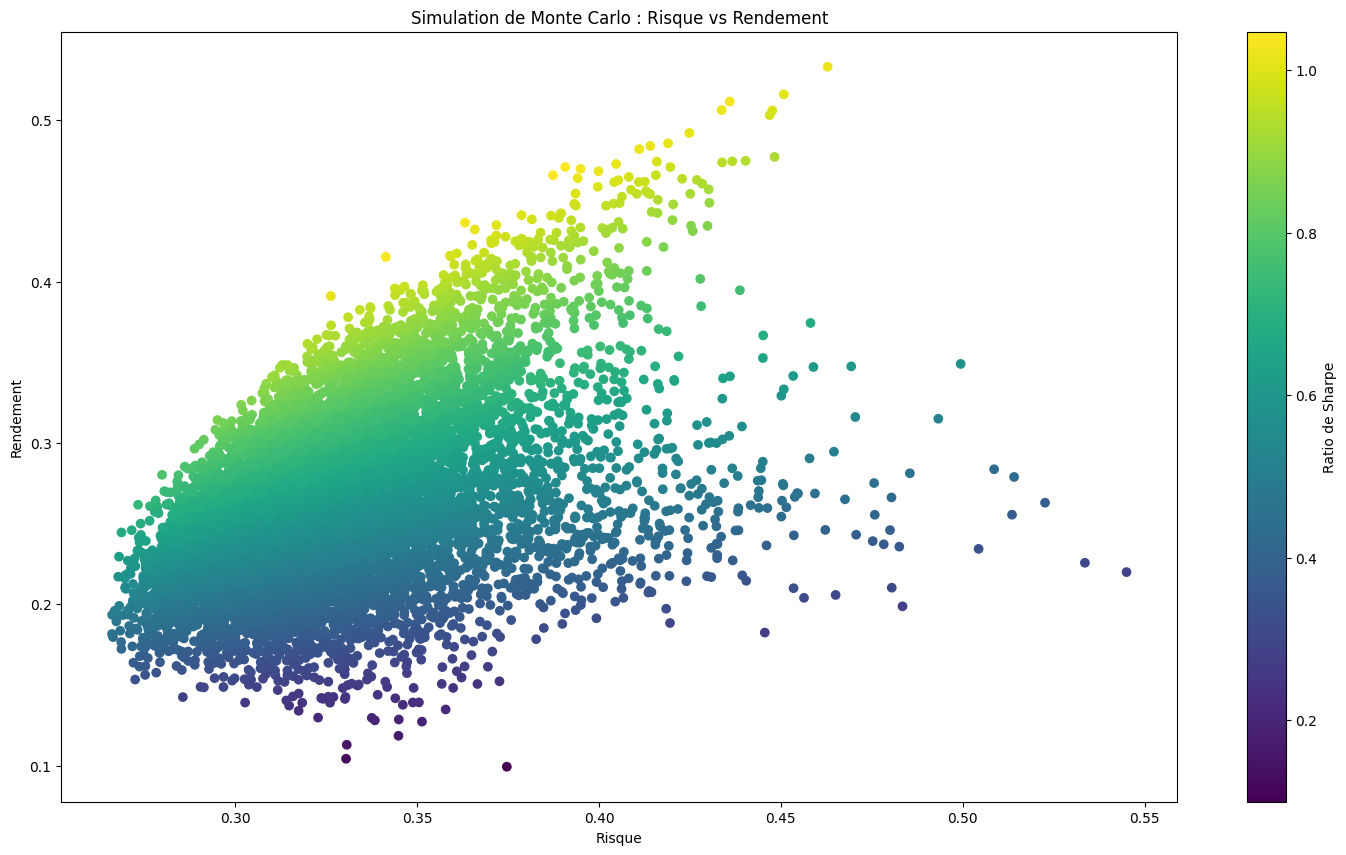

In [28]:
def monte_carlo_simulation(iterations, daily_returns, num_assets):
    """Simule des portefeuilles aléatoires et calcule leurs performances."""
    portfolio_returns = []
    portfolio_risks = []
    portfolio_sharpe_ratios = []
    for _ in range(iterations):
        weights = generate_random_weights(num_assets)
        portfolio_stats = calculate_portfolio_performance(weights, daily_returns)
        portfolio_returns.append(portfolio_stats["return"])
        portfolio_risks.append(portfolio_stats["risk"])
        portfolio_sharpe_ratios.append(portfolio_stats["sharpe_ratio"])

    return (
        np.array(portfolio_returns),
        np.array(portfolio_risks),
        np.array(portfolio_sharpe_ratios),
    )


# Exécution de la simulation
portfolio_returns, portfolio_risks, portfolio_sharpe_ratios = monte_carlo_simulation(
    10000, daily_returns, len(tickers)
)

# Visualisation des résultats
plt.figure(figsize=(18, 10))
plt.scatter(
    portfolio_risks, portfolio_returns, c=portfolio_sharpe_ratios, cmap="viridis"
)
plt.colorbar(label="Ratio de Sharpe")
plt.title("Simulation de Monte Carlo : Risque vs Rendement")
plt.xlabel("Risque")
plt.ylabel("Rendement")
plt.show()


 ## 10. Frontière Efficiente
 Nous traçons la frontière efficiente, qui représente les portefeuilles optimaux pour chaque niveau de risque.

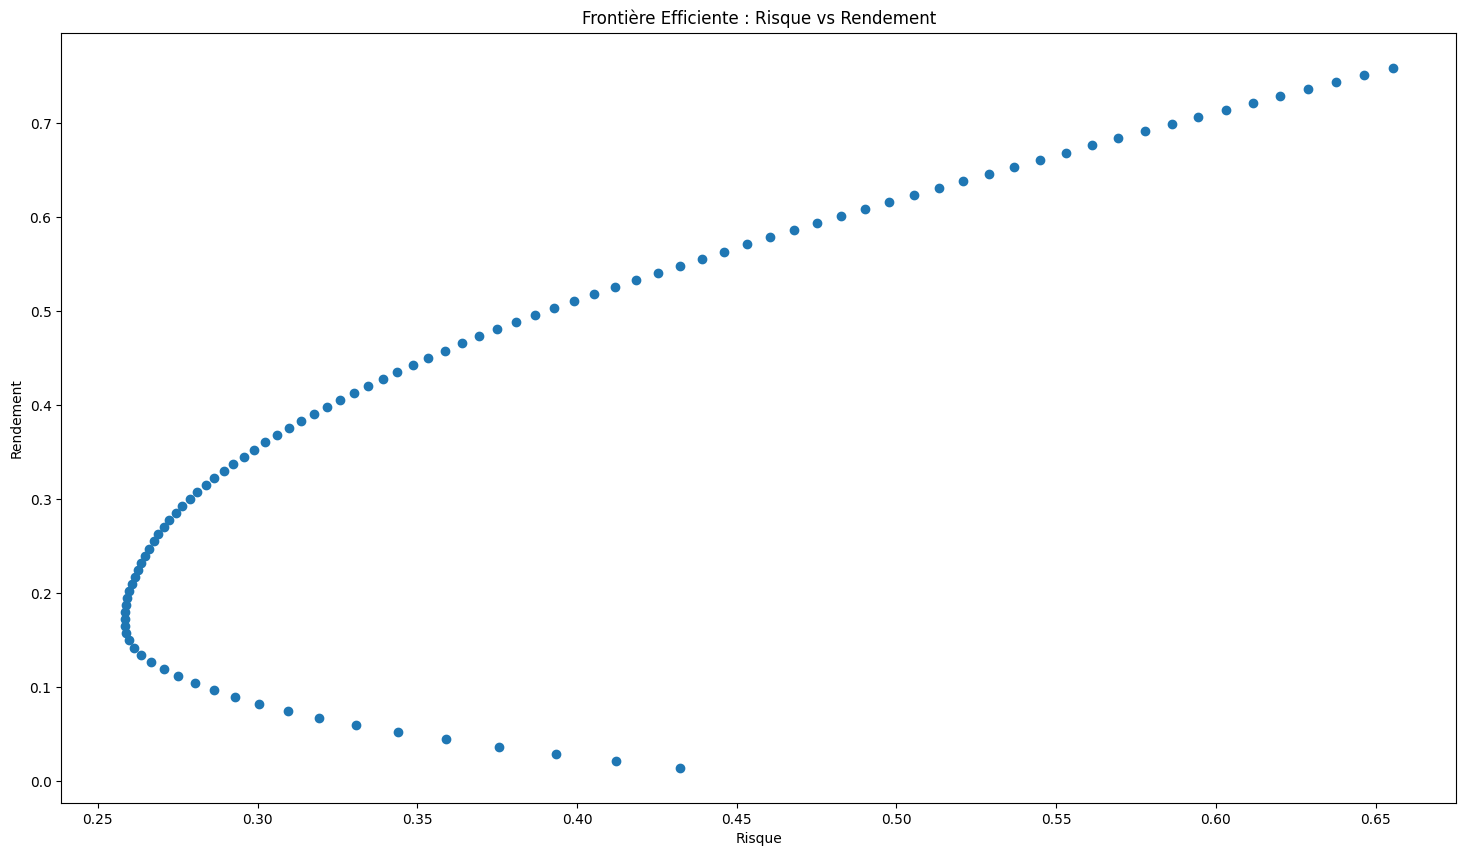

In [29]:
def efficient_frontier(daily_returns, num_assets, returns_range):
    """Calcule la frontière efficiente."""
    efficient_portfolios = []
    for target_return in returns_range:
        result = optimize_for_given_return(target_return, daily_returns, num_assets)
        weights = result.x
        portfolio_stats = calculate_portfolio_performance(weights, daily_returns)
        efficient_portfolios.append(
            (portfolio_stats["return"], portfolio_stats["risk"])
        )

    return np.array(efficient_portfolios)


# Génération de la frontière efficiente
returns_range = np.linspace(min(annualized_returns), max(annualized_returns), 100)
efficient_portfolios = efficient_frontier(daily_returns, len(tickers), returns_range)

# Visualisation
plt.figure(figsize=(18, 10))
plt.scatter(efficient_portfolios[:, 1], efficient_portfolios[:, 0])
plt.title("Frontière Efficiente : Risque vs Rendement")
plt.xlabel("Risque")
plt.ylabel("Rendement")
plt.show()


 ## 11. Visualisation Finale
 Nous superposons tous les résultats pour une vue d'ensemble.

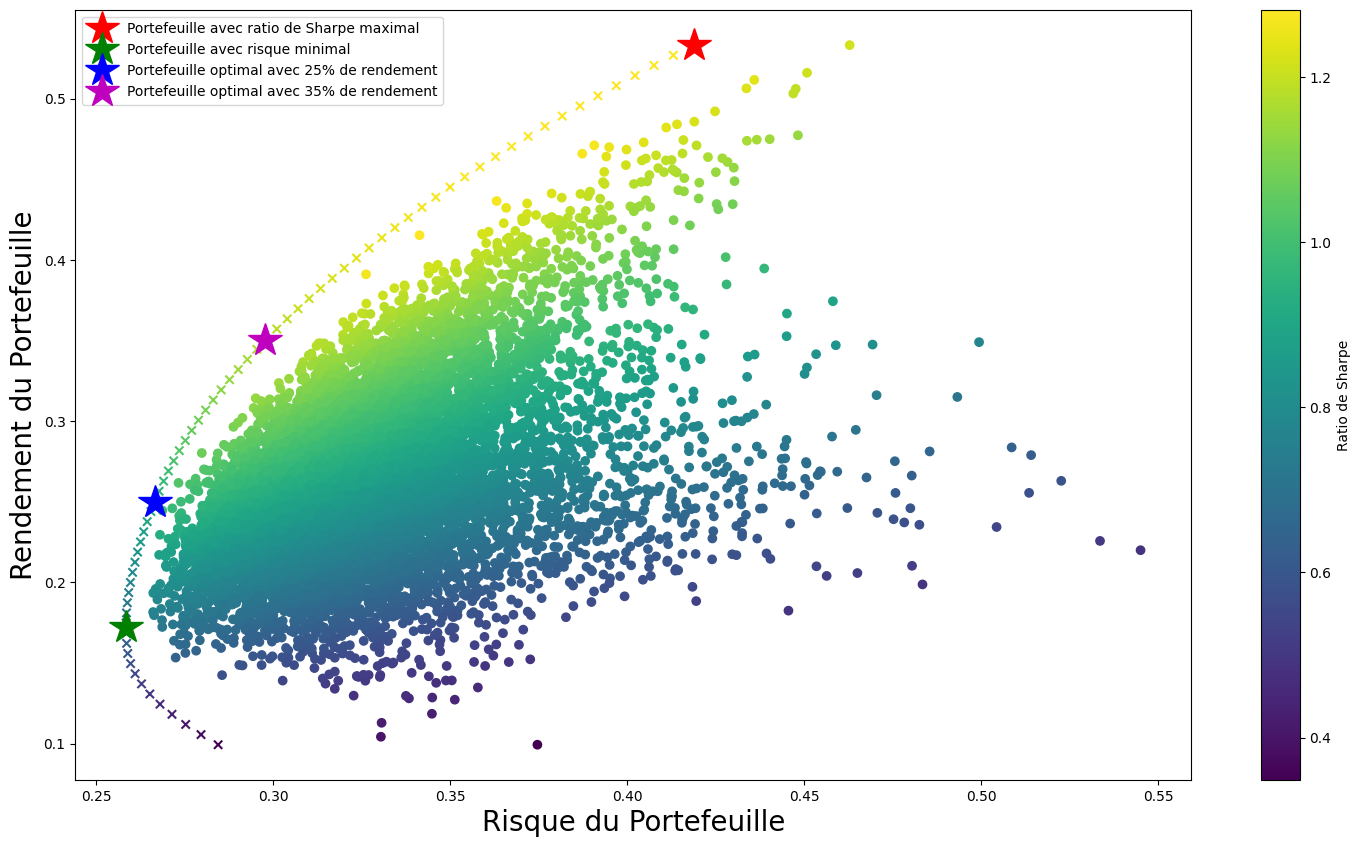

In [30]:
# Calcul des risques minimaux pour des rendements cibles
target_returns = np.linspace(portfolio_returns.min(), portfolio_returns.max(), 70)
minimal_risks = []
for target_return in target_returns:
    optimal = optimize_for_given_return(target_return, daily_returns, len(tickers))
    minimal_risks.append(optimal["fun"])

minimal_risks = np.array(minimal_risks)

# Visualisation finale
plt.figure(figsize=(18, 10))

# Tous les portefeuilles simulés
plt.scatter(
    portfolio_risks,
    portfolio_returns,
    c=(portfolio_returns / portfolio_risks),
    marker="o",
)

# Frontière efficiente
plt.scatter(
    minimal_risks, target_returns, c=(target_returns / minimal_risks), marker="x"
)

# Portefeuilles optimaux
optimal_sr_weights = optimize_with_max_sharpe_ratio(daily_returns, len(tickers)).x
plt.plot(
    calculate_portfolio_performance(optimal_sr_weights, daily_returns)["risk"],
    calculate_portfolio_performance(optimal_sr_weights, daily_returns)["return"],
    "r*",
    markersize=25.0,
    label="Portefeuille avec ratio de Sharpe maximal",
)

optimal_min_risk_weights = optimize_min_risk(daily_returns, len(tickers)).x
plt.plot(
    calculate_portfolio_performance(optimal_min_risk_weights, daily_returns)["risk"],
    calculate_portfolio_performance(optimal_min_risk_weights, daily_returns)["return"],
    "g*",
    markersize=25.0,
    label="Portefeuille avec risque minimal",
)

optimal_25_returns = optimize_for_given_return(0.25, daily_returns, len(tickers)).x
plt.plot(
    calculate_portfolio_performance(optimal_25_returns, daily_returns)["risk"],
    calculate_portfolio_performance(optimal_25_returns, daily_returns)["return"],
    "b*",
    markersize=25.0,
    label="Portefeuille optimal avec 25% de rendement",
)

optimal_35_returns = optimize_for_given_return(0.35, daily_returns, len(tickers)).x
plt.plot(
    calculate_portfolio_performance(optimal_35_returns, daily_returns)["risk"],
    calculate_portfolio_performance(optimal_35_returns, daily_returns)["return"],
    "m*",
    markersize=25.0,
    label="Portefeuille optimal avec 35% de rendement",
)

plt.xlabel("Risque du Portefeuille", fontsize=20)
plt.ylabel("Rendement du Portefeuille", fontsize=20)
plt.legend(prop={"size": 10})
plt.colorbar(label="Ratio de Sharpe")
plt.show()